In [5]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

from keras import Model,layers

In [6]:
from google.colab import drive

In [7]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [8]:
HOME_DIR = '/content/gdrive/MyDrive/dataset'

In [9]:
import tensorflow as tf

In [10]:
Train_dir = '/content/gdrive/MyDrive/dataset/Training'

In [11]:
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
    '/content/gdrive/MyDrive/dataset/Training',
    target_size=(96,96),
    shuffle=True,
    batch_size=64,
    class_mode='categorical'
)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    '/content/gdrive/MyDrive/dataset/Testing',
    target_size=(96,96),
    shuffle=False,
    batch_size=64,
    class_mode='categorical'
)


Found 2870 images belonging to 4 classes.
Found 389 images belonging to 4 classes.


In [12]:
VAL_DIR=HOME_DIR+'/Testing'

In [13]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    directory=VAL_DIR,
    target_size=(96,96),
    batch_size=64,
    shuffle=True,
    class_mode='categorical',
    classes=["no_tumor", "glioma_tumor", "meningioma_tumor", "pituitary_tumor"]
)


Found 389 images belonging to 4 classes.


In [14]:
from keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D

model = InceptionResNetV2(include_top=False,weights='imagenet')
classifier = models.Sequential()
classifier.add(model)
classifier.add(layers.GlobalAveragePooling2D())
classifier.add(Dense(4, activation='softmax'))
# compile model
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [15]:
classifier.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, None, None, 1536)  54336736 
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 4)                 6148      
                                                                 
Total params: 54,342,884
Trainable params: 54,282,340
Non-trainable params: 60,544
_________________________________________________________________


In [16]:
from sklearn.metrics import roc_auc_score

def auc(y_true, y_pred):
    return roc_auc_score(y_true, y_pred, multi_class='ovr')

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(),
        auc,
        tf.keras.metrics.Precision(name='precision', class_id=0),
        tf.keras.metrics.Recall(name='recall', class_id=0)
    ]
)


In [17]:
classes = sorted(os.listdir(Train_dir))

In [18]:
class_counts = np.array([len(os.listdir(os.path.join(Train_dir, i))) for i in classes])
class_weights = class_counts.sum() / (class_counts.shape[0] * class_counts)
class_weights_dict = {i: w for i, w in enumerate(class_weights)}

In [19]:
h1 = classifier.fit(
    train_generator,
    epochs=10,
    batch_size=16,
    validation_data=test_generator,
    verbose=1,
    class_weight=class_weights_dict
)


Epoch 1/10
45/45 [==============================] - 712s 14s/step - loss: 0.7805 - accuracy: 0.7613 - val_loss: 6.8059 - val_accuracy: 0.2725
Epoch 2/10
45/45 [==============================] - 647s 14s/step - loss: 0.2521 - accuracy: 0.9080 - val_loss: 5.7118 - val_accuracy: 0.2545
Epoch 3/10
45/45 [==============================] - 660s 15s/step - loss: 0.2511 - accuracy: 0.9286 - val_loss: 3.8939 - val_accuracy: 0.2211
Epoch 4/10
45/45 [==============================] - 680s 15s/step - loss: 0.1663 - accuracy: 0.9564 - val_loss: 4.4267 - val_accuracy: 0.2956
Epoch 5/10
45/45 [==============================] - 657s 15s/step - loss: 0.1467 - accuracy: 0.9613 - val_loss: 5.0809 - val_accuracy: 0.2622
Epoch 6/10
45/45 [==============================] - 636s 14s/step - loss: 0.0794 - accuracy: 0.9774 - val_loss: 4.9584 - val_accuracy: 0.2468
Epoch 7/10
45/45 [==============================] - 657s 15s/step - loss: 0.0620 - accuracy: 0.9780 - val_loss: 6.4189 - val_accuracy: 0.2879
Epoch 

In [20]:
from keras.callbacks import History

In [21]:
print(h1.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


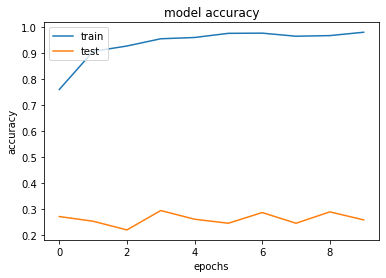

In [22]:
plt.plot(h1.history['accuracy'])
plt.plot(h1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train','test'],loc='upper left')
plt.show()

In [1]:
plt.plot(h1.history['loss'])
plt.plot(h1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train','validation'],loc='upper left')
plt.show()

NameError: ignored